<a href="https://colab.research.google.com/github/aliciafmachado/amf-challenge/blob/main/Project_INF569_Iago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who are the high-frequency traders ?
### by Autorité des Marchés Financiers


Alicia Fortes Machado & Iago Martinelli Lopes

This notebook explore different techniques in order to classify the traders within three categories: HFT, non-HFT and MIX.

The dataset has 35 variables explaining statistics for each set of market player, stock and specific trading date.

## Connect to Google Drive

We connect to Google Drive if you chose this option.

If not, you can jump this section.

In [46]:
# Import and save into google drive
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/MAP569/project'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/MAP569/project'
/content/drive/My Drive/MAP569/project
build/  data/                result.csv            tsne_model.pkl
cuml/   rapidsai-csp-utils/  result_naive_cls.csv


## Import libraries

We import all necessary libraries:

In [47]:
!pip install prince
!pip install seaborn

In [104]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(style='ticks')

## Dataset

We first open the dataset:

In [49]:
# main path to our dataset
data_path = "data"

train_x_path = os.path.join(data_path, 'AMF_train_X_XCZw8r3.csv')
train_y_path = os.path.join(data_path, 'AMF_train_Y_omYQJZL.csv')

eval_path = os.path.join(data_path, 'AMF_test_X_uDs0jHH.csv')

train_x_df = pd.read_csv(train_x_path, index_col='Index')
train_y_df = pd.read_csv(train_y_path, index_col=None)

eval_df = pd.read_csv(eval_path, index_col='Index')

In [50]:
train_x_df.head(2)

,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
Index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,23151.8380,25139.598,682.153260,8272.770569,682.153260,984.32056,682.15326,23151.8380,23151.838,23151.838,1,7,2.750000,351.702399,9639.216031,1585.079495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,2671.4883,31278.357,11.866026,3796.632686,11.866026,177.93991,73.74323,808.2623,21433.684,21433.684,1,17,5.933333,0.000066,493.559196,0.000901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15


In [51]:
train_x_df.describe()

,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade
count,104099.000000,105782.000000,58170.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,105782.000000,101547.000000,101547.000000,101547.000000,80606.000000,80606.000000,80606.000000,80527.000000,80527.000000,80527.000000,80634.000000,80634.000000,80634.000000,105782.000000
mean,34.435038,17.458787,164.469153,87.472164,2772.513578,103.310102,1011.630575,228.659560,4734.942457,9786.032539,24292.035085,1945.038027,5616.519744,2070.233540,4445.109364,2707.080480,8451.108964,11587.949910,19980.278762,5.563896,25.249324,2.093446,438.447418,1082.427774,651.743386,297.616104,598.637740,389.411017,310.498829,605.733603,401.594794,309.912605,615.154194,402.749527,334.034070
std,137.261154,71.843225,929.010848,1549.972501,4985.149536,1617.051421,4967.426924,2319.866837,10431.964706,14256.357615,17772.438572,6672.112738,9140.189971,6809.714060,9372.947978,7531.875480,13270.509124,15667.418368,17654.559859,4.385260,35.264111,1.417188,2876.755745,3187.357171,2931.984342,1882.353978,2010.296401,1896.835552,1922.648030,2031.797111,1933.073024,1910.028651,2037.041672,1923.023720,644.816702
min,1.044444,2.000000,1.001960,0.000000,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,0.000065,0.000007,0.000038,0.000016,0.000035,0.000028,0.000038,0.000038,0.000038,1.000000,1.000000,1.000000,0.000001,0.000001,0.000001,0.000001,0.000002,0.000001,0.000001,0.000003,0.000002,0.000001,0.000008,0.000003,1.000000
25%,3.709023,2.753802,3.253655,0.000000,69.365666,0.000000,1.243868,0.000024,22.249021,117.771340,4410.907350,0.000583,67.897392,0.043414,6.234451,0.746623,30.724017,109.431107,1902.260450,2.000000,6.000000,1.500000,0.000007,50.921032,4.915512,0.000005,33.819189,2.533583,0.000006,32.699571,2.305276,0.000020,33.713187,2.639113,24.000000
50%,7.346154,4.789474,14.000000,0.000000,262.325253,0.000109,10.154920,0.093957,114.957445,480.715195,30166.389500,0.044144,272.333702,1.663752,35.734245,8.251923,182.259375,596.792220,17972.680000,5.000000,14.000000,1.880000,0.000091,183.022816,36.457000,0.000232,110.427370,22.413161,0.000260,111.633327,23.665962,0.000270,113.158721,23.435835,97.000000
75%,22.707956,16.366667,73.689116,0.000000,3801.273320,0.020739,60.552090,2.836749,2277.450350,20975.263250,37485.990000,35.497842,9185.177948,69.218030,2075.455025,254.888130,16302.060250,23952.383000,35716.844000,8.000000,30.000000,2.313703,0.001000,714.761762,227.236491,0.008000,367.974973,121.244211,0.051880,376.874393,127.408500,0.059669,380.865913,128.108940,342.000000
max,17561.000000,14409.000000,127861.000000,52568.766000,52568.765625,52568.766000,52568.766000,52568.766000,60597.414000,60609.660000,71934.490000,53171.766000,53171.765625,53171.766000,53171.766000,53171.766000,53646.010000,53909.210000,53909.210000,24.000000,909.000000,63.000000,30929.771000,30929.771000,30929.771000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,30904.835000,12966.000000


We will join our train_x_df and train_y_df in order to better visualize our problem.

In [52]:
# add label in train_x
train_x_df = pd.merge(train_x_df, train_y_df, left_on="Trader", right_on="Trader")
train_x_df.head(2)

,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,23151.8380,25139.598,682.153260,8272.770569,682.153260,984.32056,682.15326,23151.8380,23151.838,23151.838,1,7,2.750000,351.702399,9639.216031,1585.079495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NON HFT
1,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,2671.4883,31278.357,11.866026,3796.632686,11.866026,177.93991,73.74323,808.2623,21433.684,21433.684,1,17,5.933333,0.000066,493.559196,0.000901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NON HFT


Now let's look at the distribution of the labels in our Dataset.

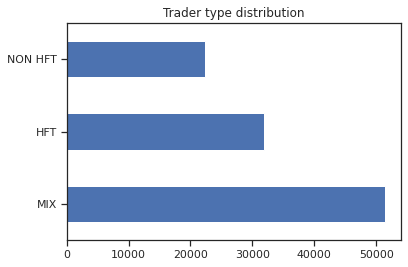

In [53]:
train_x_df['type'].value_counts().plot.barh()
plt.title("Trader type distribution")
plt.show()

To conclude this first step, our Dataset is a little unbalanced. There are much more trades performed by a MIX Trader than trades performed by NON FHT Traders. But it is not extremelly unbalanced to the point of compromising models. In any case, F1-Score looks like a better metric to evaluate the model comapred to accuracy.

Then, we transform the date and the stock identification code to integers:

# NaN Values

The first thing we notice in our Dataset is the presence of NaN values, and this occurs mainly because there are Traders who uses only one Trading Venue to trade. So, most of our NaN values do not correspond to a missing information, so we need to treat them in a different way than simply dropping the columns and rows, or replacing them with the average.

To begin, we will see which columns have missing values, how many rows and its importance for our problem.

In [54]:
train_x_df.isnull().sum()

Share                             0
Day                               0
Trader                            0
OTR                            1683
OCR                               0
OMR                           47612
min_time_two_events               0
mean_time_two_events              0
10_p_time_two_events              0
med_time_two_events               0
25_p_time_two_events              0
75_p_time_two_events              0
90_p_time_two_events              0
max_time_two_events               0
min_lifetime_cancel               0
mean_lifetime_cancel              0
10_p_lifetime_cancel              0
med_lifetime_cancel               0
25_p_lifetime_cancel              0
75_p_lifetime_cancel              0
90_p_lifetime_cancel              0
max_lifetime_cancel               0
NbTradeVenueMic                   0
MaxNbTradesBySecond               0
MeanNbTradesBySecond              0
min_dt_TV1                     4235
mean_dt_TV1                    4235
med_dt_TV1                  

As expected, the majority of NaN values correspond to the column values of TV from 2 to 4. It means that these Traders do not use these Trading Venues, and we must use this information in our problem.

Now, we will plot some graphs to observe how relevant these NaN values are.

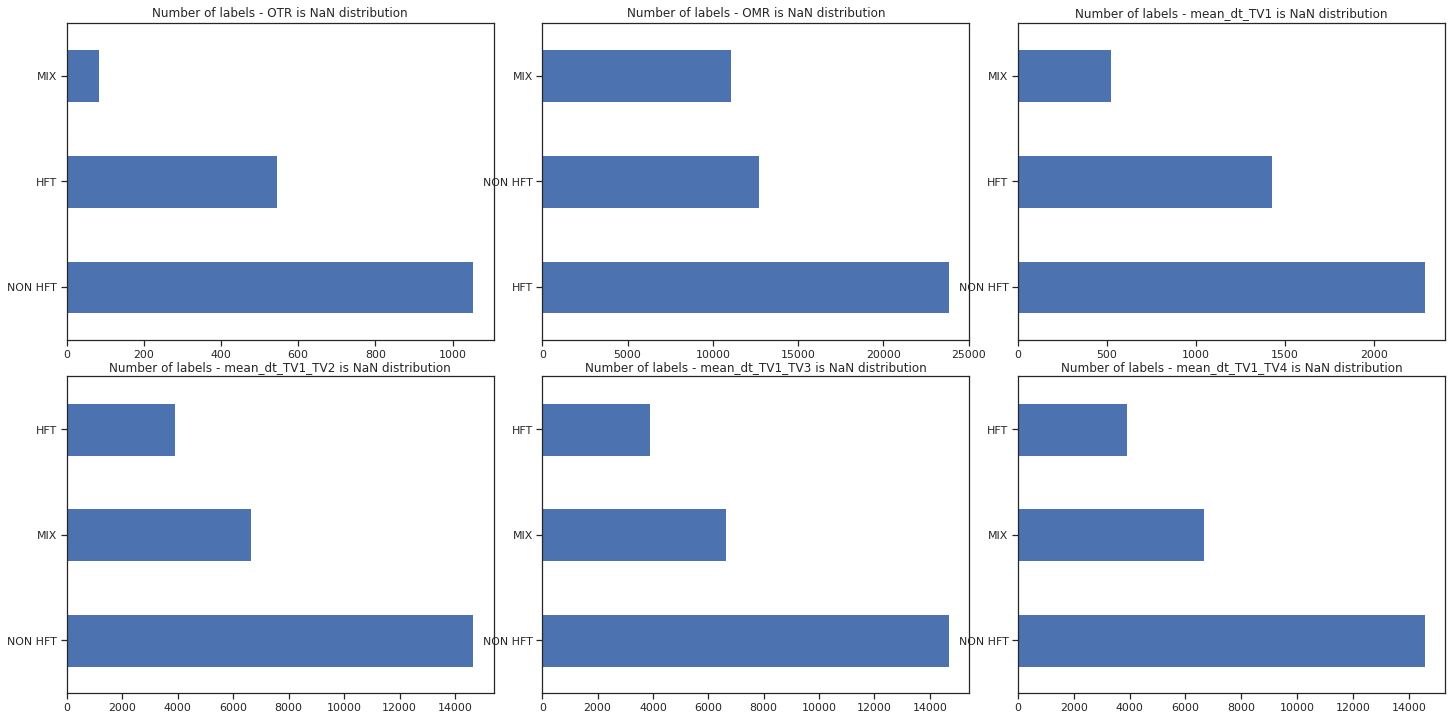

In [55]:
labels = ["OTR", "OMR", "mean_dt_TV1", "mean_dt_TV1_TV2", "mean_dt_TV1_TV3", "mean_dt_TV1_TV4"]
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.tight_layout()
label_idx = 0
for i in range(2):
  for j in range(3):
    place = axs[i, j]
    if label_idx == len(labels):
      continue
    label = labels[label_idx]
    train_x_only_nan = train_x_df[train_x_df[label].isna()]
    train_x_only_nan['type'].value_counts().plot(kind="barh", ax=place)
    place.set_title("Number of labels - {} is NaN distribution".format(label))
    label_idx += 1

plt.show()

In conclusion, the rows that have NaN values follow a different distribution compared to all values together. While the distribution of all values have a majority of MIX Traders, when we consider only NaN values rows it changes a lot. 

In order to not lose this important information that NaN values give to us, we will not replace it my the average column value or drop it, we will replace it by -1, and it will mean that there are no values there, but at the same time we will be able to use this NaN value information in our models.

In [56]:
# replace NaN values for -1
train_x_df = train_x_df.fillna(-1)
eval_df = eval_df.fillna(-1)

## Visualization

In this next step, we will visualize our data to identify any obvious relation, to check if our dataset is balanced and to see which variables are more relavant to our problem. We also may check for correlations in order to apply some algorithms to reduce dimensionality.

In [146]:
def pre_processing(df):
  """
  Pre process our dataset
  """
  return df.drop(columns=['Trader', 'Day', 'Share'])
X_visualize = pre_processing(train_x_df)

## Correlation

As we have a lot of variables, and many of them seem to have a strong correlation (like variables describing tradings), we will plot below a heatmap with the correlation values.

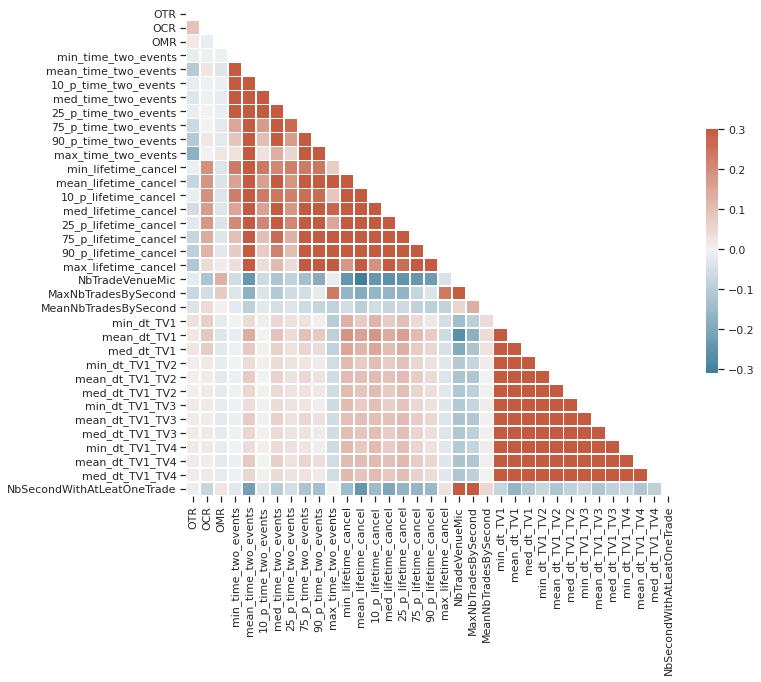

In [97]:
corr = X_visualize.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

As expected, variables like min_dt_TV1, mean_dt_TV1, ..., are strongly correlated, and also the statistics about time between two events and lifetime cancel of orders. So a PCA is a good idea to reduce the dimension while maintaining the quality. Below, we plot the PCA for all variables, and after we plot the PCA for only the selected variables which we know that are correlated.

In [143]:
def apply_PCA(df, columns, n_components):
  df = df[columns]
  if 'type' in df:
    df.drop(columns=['type'], inplace=True)
  sc = StandardScaler()
  pca = PCA(n_components=n_components)
  pca_data = sc.fit_transform(df)
  principalComponents = pca.fit_transform(pca_data)
  return pca, principalComponents

def visualize_PCA(df, columns, pca, principalComponents):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))
  fig.tight_layout(pad=3)

  label = df['type']
  df = df[columns]
  if 'type' in df:
    df.drop(columns=['type'], inplace=True)
  pca_values=pca.components_

  PC_values = np.arange(pca.n_components_) + 1
  axs[0, 0].plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
  axs[0, 0].set_title('Scree Plot')
  axs[0, 0].set_xlabel('Principal Component')
  axs[0, 0].set_ylabel('Proportion of Variance Explained')

  #Plot circle - dim 2 and 3
  #Create a list of 500 points with equal spacing between -1 and 1
  x=np.linspace(start=-1,stop=1,num=500)
  #Find y1 and y2 for these points
  y_positive=lambda x: np.sqrt(1-x**2) 
  y_negative=lambda x: -np.sqrt(1-x**2)
  axs[0, 1].plot(x,list(map(y_positive, x)), color='black')
  axs[0, 1].plot(x,list(map(y_negative, x)),color='black')

  #Create broken lines
  x=np.linspace(start=-1,stop=1,num=30)
  axs[0, 1].scatter(x,[0]*len(x), marker='_',color='black')
  axs[0, 1].scatter([0]*len(x), x, marker='|',color='black')

  add_string=""
  for i in range(len(pca_values[0])):
      xi=pca_values[0][i]
      yi=pca_values[1][i]
      axs[0, 1].arrow(0,0, 
                dx=xi, dy=yi, 
                head_width=0.03, head_length=0.03,
                color='black',
                length_includes_head=True)
      axs[0, 1].text(pca_values[0, i], 
              pca_values[1, i] , 
              s=columns[i] + add_string )
      
  axs[0, 1].set_xlabel(f"Component 1 ({round(pca.explained_variance_ratio_[0]*100,2)}%)")
  axs[0, 1].set_ylabel(f"Component 2 ({round(pca.explained_variance_ratio_[1]*100,2)}%)")
  axs[0, 1].set_title('Variable factor map (PCA) dim 2 and 3')

  df_pca = pd.DataFrame()
  df_pca['pca-one'] = principalComponents[:,0]
  df_pca['pca-two'] = principalComponents[:,1] 
  df_pca['pca-three'] = principalComponents[:,2]
  df_pca['type'] = label

  sns.scatterplot(
      x="pca-one", y="pca-two",
      hue="type",
      palette=sns.color_palette("hls", 3),
      data=df_pca,
      legend="full",
      alpha=0.3,
      ax=axs[1, 0]
  )
  axs[1, 0].set_title("PCA - Dimension 1 and 2")

  sns.scatterplot(
      x="pca-two", y="pca-three",
      hue="type",
      palette=sns.color_palette("hls", 3),
      data=df_pca,
      legend="full",
      alpha=0.3,
      ax=axs[1, 1]
  )
  axs[1, 1].set_title("PCA - Dimension 2 and 3")

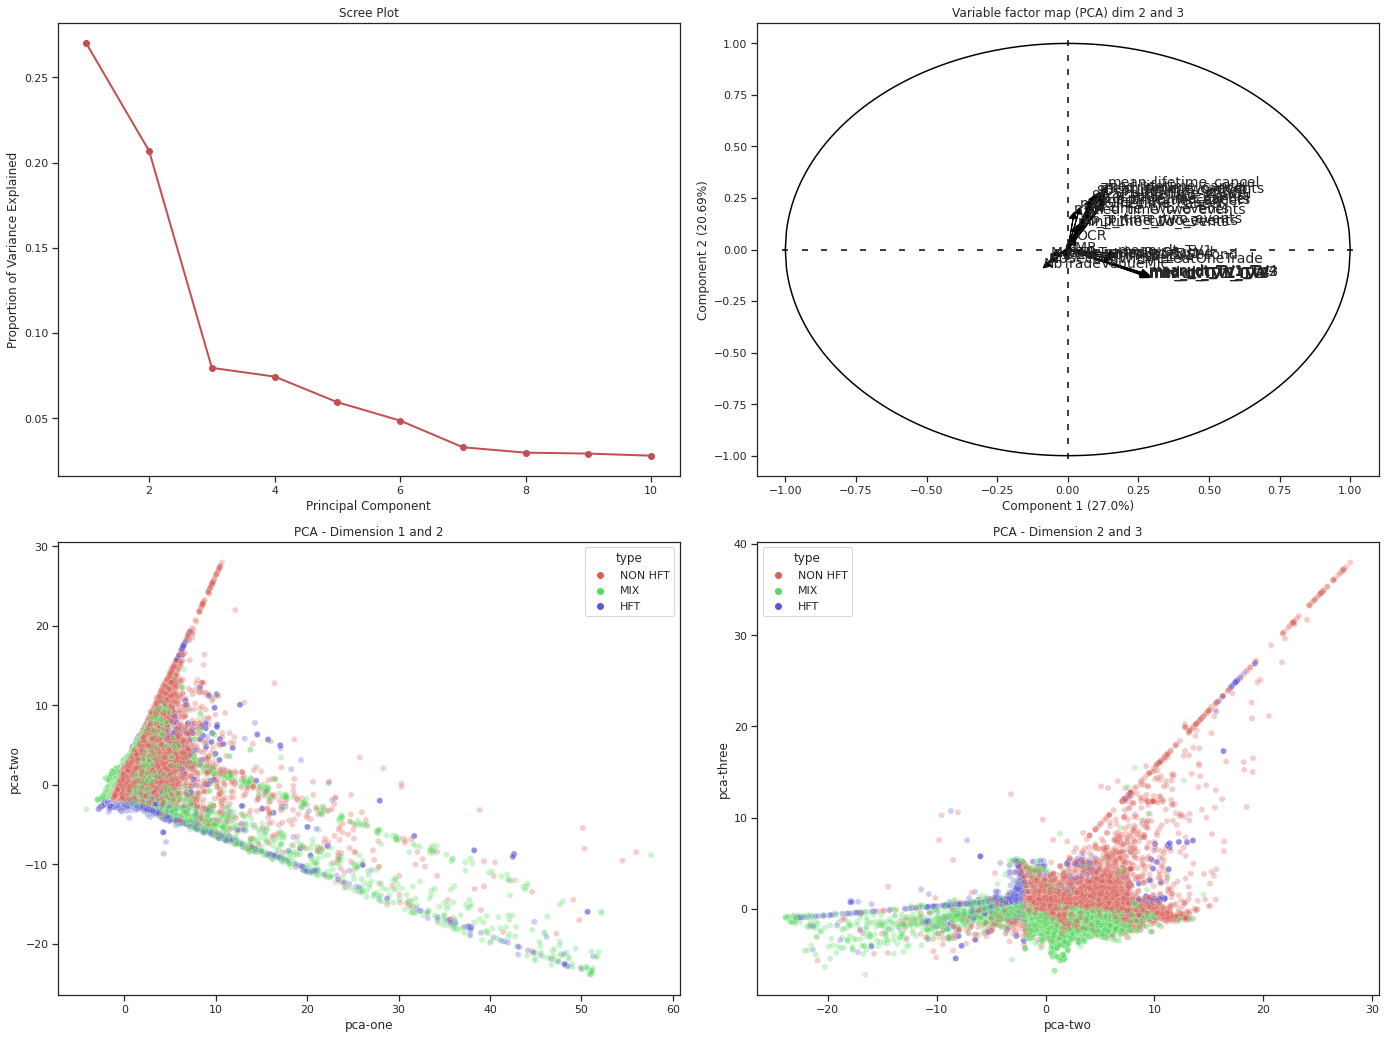

In [144]:
pca, principalComponents = apply_PCA(X_visualize, X_visualize.columns, 10)
visualize_PCA(X_visualize, X_visualize.columns, pca, principalComponents)
plt.show()

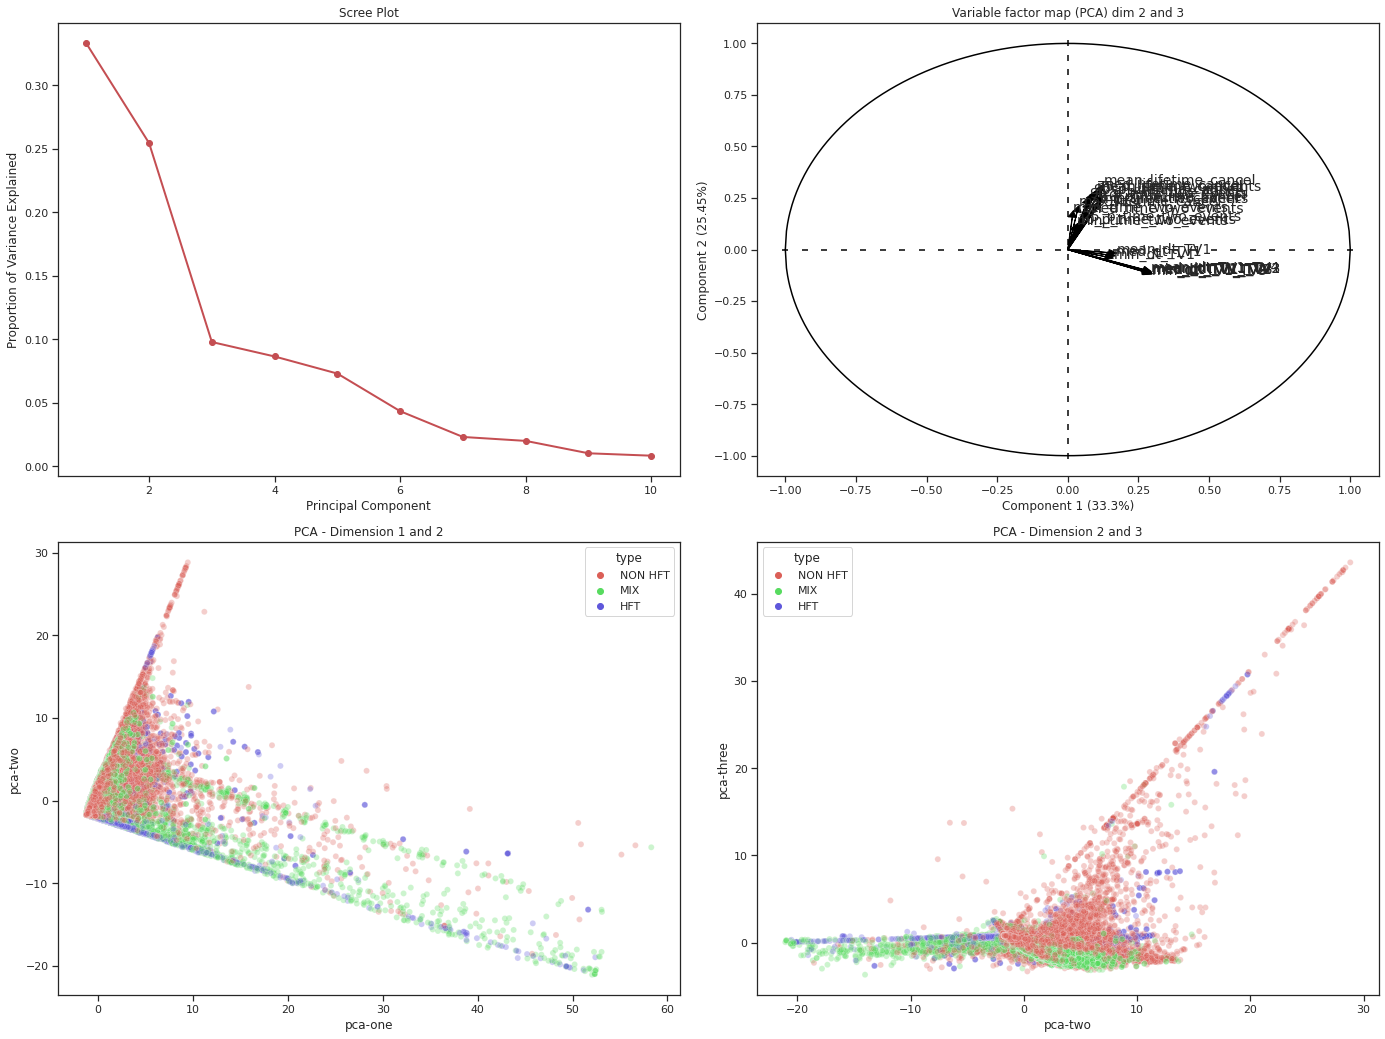

In [145]:
columns = ["min_time_two_events","mean_time_two_events","10_p_time_two_events","med_time_two_events",
          "25_p_time_two_events","75_p_time_two_events","90_p_time_two_events","max_time_two_events",
          "min_lifetime_cancel","mean_lifetime_cancel","10_p_lifetime_cancel","med_lifetime_cancel",
          "25_p_lifetime_cancel","75_p_lifetime_cancel","90_p_lifetime_cancel","max_lifetime_cancel",
          "min_dt_TV1","mean_dt_TV1","med_dt_TV1","min_dt_TV1_TV2","mean_dt_TV1_TV2","med_dt_TV1_TV2",
          "min_dt_TV1_TV3","mean_dt_TV1_TV3","med_dt_TV1_TV3","min_dt_TV1_TV4","mean_dt_TV1_TV4",
          "med_dt_TV1_TV4"]

pca, principalComponents = apply_PCA(X_visualize, columns, 10)
visualize_PCA(X_visualize, columns, pca, principalComponents)
plt.show()

#### TODO: CONCLUDE PCA ANALYSIS

## Plots

Below, we plot the distribution of each variable normalized. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


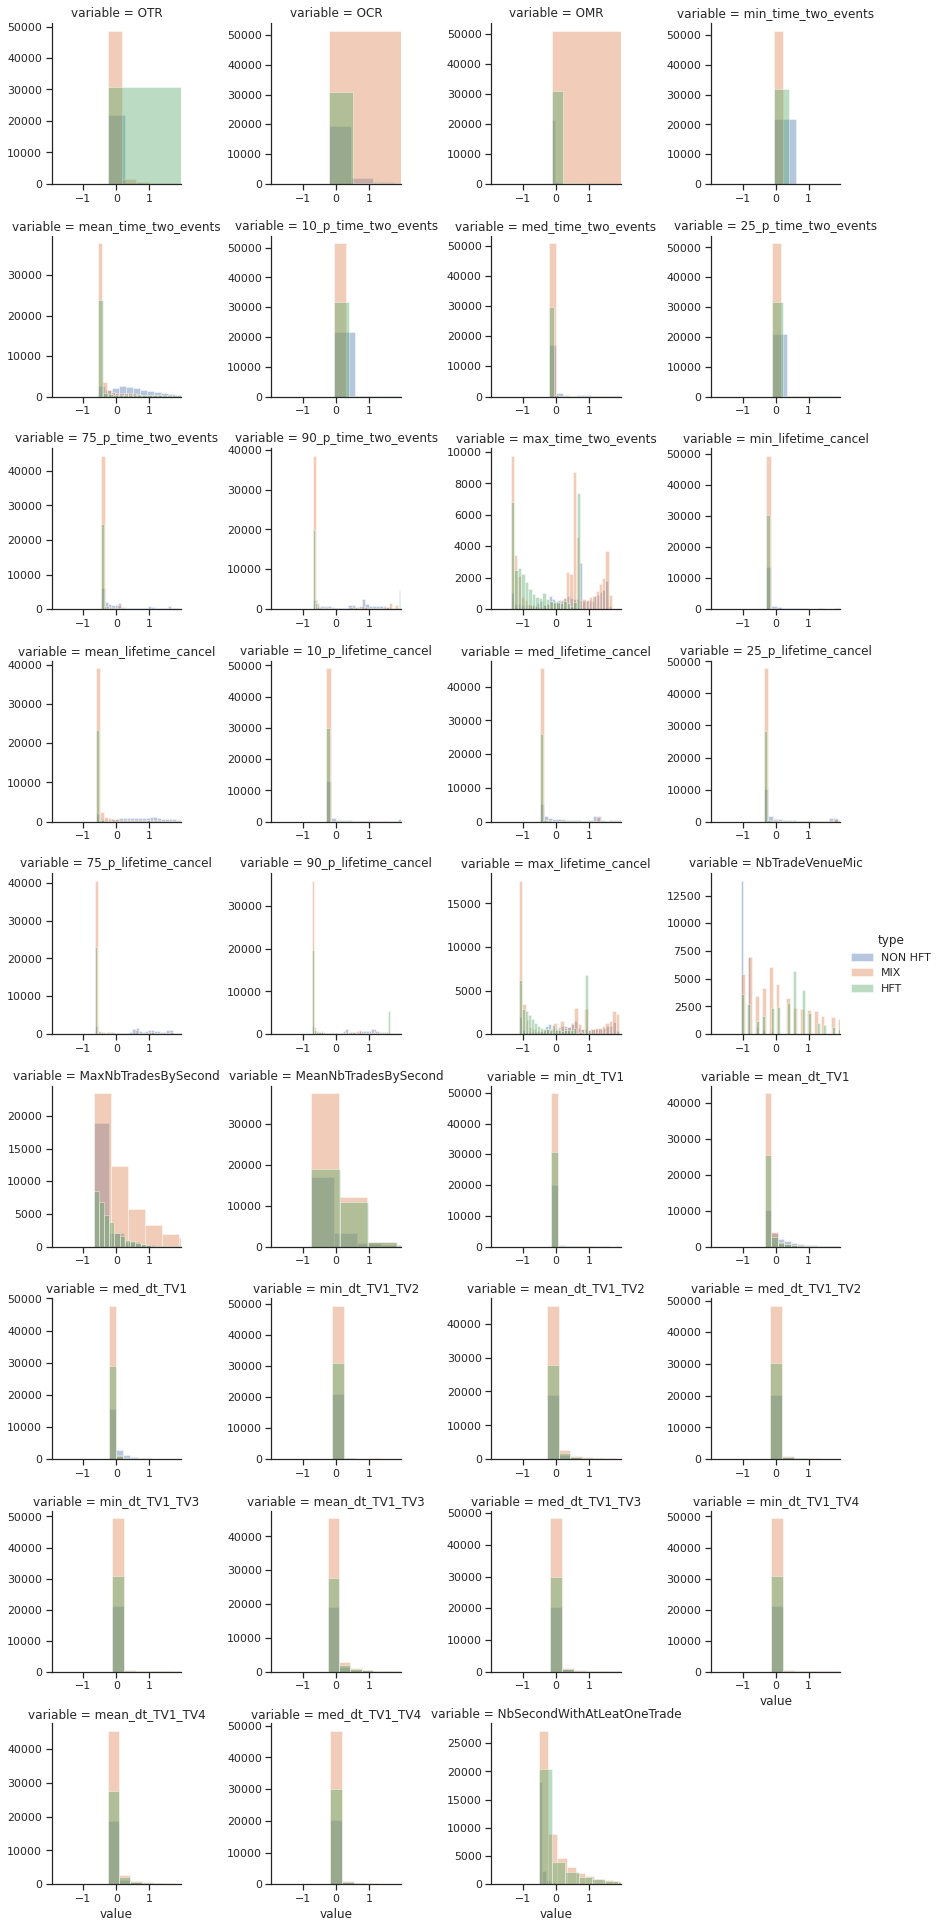

In [155]:
X_norm, y = X_visualize.drop(columns=['type']), X_visualize['type']
X_norm = (X_norm - X_norm.mean()) / X_norm.std()
X_norm = X_norm.merge(y, left_index=True, right_index=True)
columns = list(X_norm.columns.values)
columns = columns.remove("type")
f = pd.melt(X_norm, id_vars='type', value_vars=columns)
g = sns.FacetGrid(f, hue='type', col="variable", col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value", kde=False).add_legend()
g.set(xlim=(-1.96, 1.96))

### TODO: CONCLUDE PLOT ANALYSIS

In relation to the traders, we can consider some variables as well. Like the number of days that the trader was active and the number of Shares that he trades.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


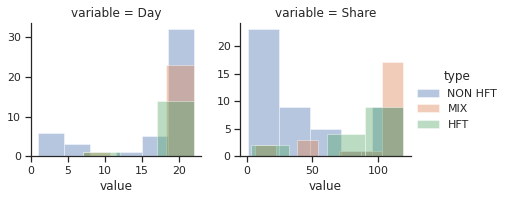

In [171]:
traders = train_x_df[['Trader', 'Day', 'Share']].copy()
traders = traders.groupby(by="Trader", axis=0).agg({'Day': 'nunique', 'Share': 'nunique'})
traders = pd.merge(traders, train_y_df, left_on="Trader", right_on="Trader")

columns = ['Day', 'Share']
f = pd.melt(traders, id_vars='type', value_vars=columns)
g = sns.FacetGrid(f, hue='type', col="variable", col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value", kde=False).add_legend()

In [162]:
train_x_df.head()

,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,mean_lifetime_cancel,10_p_lifetime_cancel,med_lifetime_cancel,25_p_lifetime_cancel,75_p_lifetime_cancel,90_p_lifetime_cancel,max_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,min_dt_TV1,mean_dt_TV1,med_dt_TV1,min_dt_TV1_TV2,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,419.688500,10.722543,984.320560,23151.83800,25139.598,682.153260,8272.770569,682.153260,984.32056,682.15326,23151.83800,23151.8380,23151.838,1,7,2.750000,351.702399,9639.216031,1585.079495,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,NON HFT
1,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,0.003374,0.000204,8.768699,2671.48830,31278.357,11.866026,3796.632686,11.866026,177.93991,73.74323,808.26230,21433.6840,21433.684,1,17,5.933333,0.000066,493.559196,0.000901,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,15,NON HFT
2,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,0.000599,0.000129,5.725427,448.88360,30799.467,2.761036,1397.103679,2.761036,187.99548,19.77734,418.23984,1953.6235,10842.464,1,20,5.063492,0.000018,163.954785,0.000770,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,63,NON HFT
3,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,6.152666,0.000945,62.444176,19187.71900,19187.719,286.019320,9736.869034,286.019320,286.01932,286.01932,19187.71900,19187.7190,19187.719,1,8,4.250000,0.000148,1232.562133,0.004301,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4,NON HFT
4,Isin_87,Date_9,Trader_10,1.517730,26.750000,-1.000000,0.0,944.008551,0.000071,0.001364,0.000146,2.225420,273.45676,23164.514,2.798452,10066.803992,2.798452,1345.95280,662.57434,21903.78300,23164.5140,23164.514,1,19,3.710526,0.000025,248.073927,0.001364,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,38,NON HFT


We do the same for the shares:

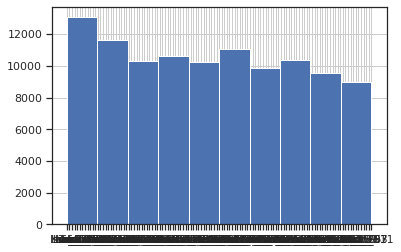

In [ ]:
train_x_df['Share'].hist()
plt.show()

## Preprocessing and Unsupervised Learning

### MFA and PCA

We apply unsupervised learning techniques to detect the parameters that are relevant to predict the right category. We use MFA since we have both categorical and continuous variables. This technique joins a PCA and a MCA, methods that are used for continuous and categorical variables, respectively. We will also apply a PCA to our dataset by dummifying the categorical variables. The problem of the last approach is that we have too many different labels for Share, Trader and Day. Thus, it might not be very effective (we only have 35 continuous variables). One option is to change them to continuous values but it is not a good practice.

TODO: DO WE TRY THIS LAST OPTION?

We also accept None as method, and then we only dummify the categorical labels.

In [ ]:
from prince import MFA
from prince import PCA

def preprocess(raw_data, reduction_method='MFA', n_components=30, dummify=False):
  # We select the categorical columns:
  traders = pd.DataFrame(raw_data[['Trader']], index=raw_data.index.copy(), columns = ["Trader"])
  transform = None

  X = raw_data.drop(columns=['Trader'])
  cat_columns = ['Share', 'Day']

  cat = X[cat_columns]
  num = X.drop(columns=cat_columns)

  # We need to normalize the numerical columns
  num = (num - num.mean()) / num.std()

  if reduction_method == 'MFA':

    X = pd.concat([num, cat], axis=1)
    groups = {
        'cat': cat_columns
    }

    transform = MFA(groups=groups, n_components=n_components, n_iter=1000)
    X = transform.fit_transform(X)

  elif (reduction_method == 'PCA' or
    reduction_method == None):
    
    if not dummify:
      # Transform not continuous variables to 
      #TODO: fix warning
      cat['Day'] = cat.Day.str.extract('(\d+)').astype(int)
      cat['Share'] = cat.Share.str.extract('(\d+)').astype(int)
    else:
      cat = pd.get_dummies(cat).astype(int)

    # We need to normalize all columns
    cat = (cat - cat.mean()) / cat.std()

    # Concatenate X
    X = pd.concat([num, cat], axis=1)

    if reduction_method == 'PCA':
      transform = PCA(n_components=n_components)
      X = transform.fit_transform(X)

  else:
    raise ValueError('Invalid reduction method: {:}. Please use MFA, PCA or None.'
    .format(reduction_method))

  X = pd.merge(traders, X, on="Index")

  return X, transform

In [ ]:
X_emb_mfa, transform_mfa = preprocess(train_x_df)

In [ ]:
%%capture
X_emb_pca, transform_pca = preprocess(train_x_df, reduction_method='PCA')
X_emb_pca_dum, transform_pca_dum = preprocess(train_x_df, reduction_method='PCA', dummify=True)

In [ ]:
%%capture
X_none, _= preprocess(train_x_df, reduction_method=None)
X_none_dum, _= preprocess(train_x_df, reduction_method=None, dummify=True)

In [ ]:
# Visualization of the PCA and MFA

def plot_embedding_space(X_emb, Y, plotting_columns=[0, 1], method='MFA', dummify=False):
  X_total = pd.merge(X_emb, Y, on="Trader")

  # Scatterplot
  ax = sns.scatterplot(data=X_total, x=plotting_columns[0], 
                  y=plotting_columns[1], hue="type", 
                  style="type")
  
  title = "First two dimensions of " + method

  if method == 'PCA':
    if dummify == False:
      title += "without dummification"
    else:
      title += "with dummification"

  ax.set_title(title)
  ax.set_xlabel("First dimension")
  ax.set_ylabel("Second dimension")

def plot_explained_inertia(transform, method='MFA', dummify=False):

  title = "Explained inertia for each dimension using " + method

  if method == 'PCA':
    if dummify == False:
      title += " without dummification"
    else:
      title += " with dummification"

  # Scatterplot
  ax = sns.barplot(x=list(range(1, 31)), y=transform.explained_inertia_)
  ax.set_title(title)
  ax.set_xlabel("Dimensions")
  ax.set_ylabel("Explained inertia")


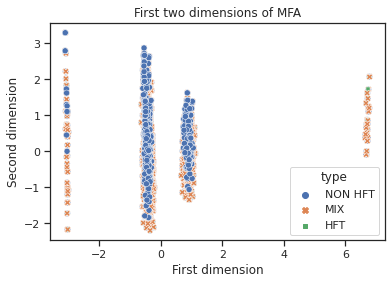

In [ ]:
plot_embedding_space(X_emb_mfa, train_y_df, method='MFA')

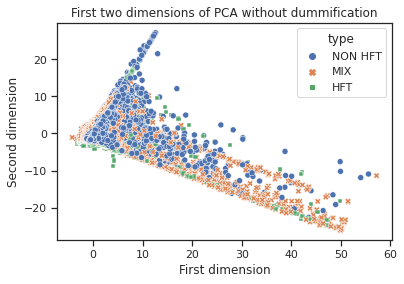

In [ ]:
plot_embedding_space(X_emb_pca, train_y_df, method='PCA')

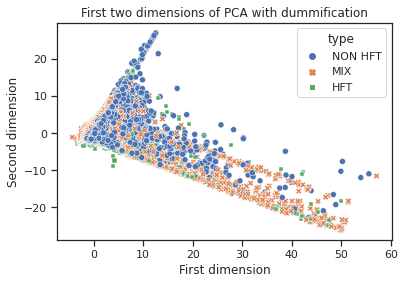

In [ ]:
plot_embedding_space(X_emb_pca_dum, train_y_df, method='PCA', dummify=True)

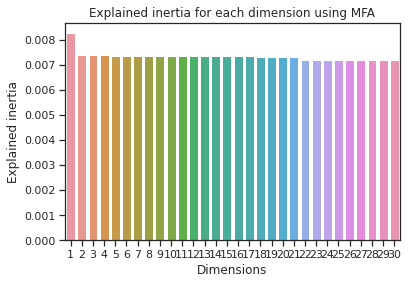

In [ ]:
plot_explained_inertia(transform_mfa, method="MFA")

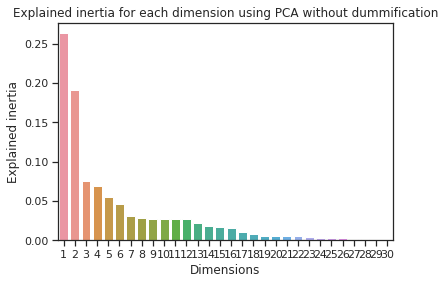

In [ ]:
plot_explained_inertia(transform_pca, method="PCA")

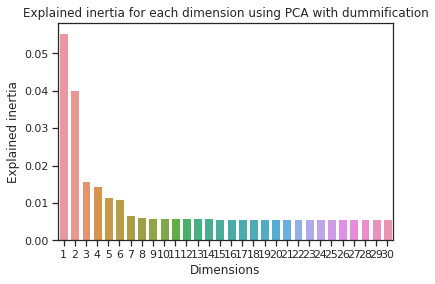

In [ ]:
plot_explained_inertia(transform_pca_dum, method="PCA", dummify=True)

In [ ]:
nb_dim = 6
variance = transform_pca.explained_inertia_[0:nb_dim].sum()

print("PCA without dummification has {:.3f} of it variance represented by {} dimensions".format(variance, nb_dim))

variance = transform_pca_dum.explained_inertia_[0:nb_dim].sum()
print("PCA with dummification has {:.3f} of it variance represented by {} dimensions".format(variance, nb_dim))


PCA without dummification has 0.699 of it variance represented by 6 dimensions
PCA with dummification has 0.149 of it variance represented by 6 dimensions


From the plots of explained inertia, we can conclude that:



*   PCA without dummification: Using this approach, we got that our data is mainly explained by the six first dimensions (69.9% of the variance). 
*   PCA with dummification: With this one, we got the same distribution considering only the first two dimensions as without dummification. However, our data is distributed differently as we can see from looking in the graph with the explained inertia. After the 8th dimension, all dimensions have almost the same value, which is near 0.01. This means that the dimensions before the 8th one are not capable to represent very well the data. The sum of the 6 first dimensions in this one is only 14.9%. 
*   MFA: For the MFA, we got that the variance of the data is distributed among all dimensions shown.

### t-SNE

 Here, we use t-sne to visualize the results of the MFA and PCA.

Notice that we decided to not consider the t-SNE technique as the output varies every time the algorithm is run.

### Clustering

In this subsection, we try to identify clusters to increase our understanding of the data.

### Conclusion

From all these methods, we realize that we should use ...

## Supervised Learning

### Loss function

In the challenge, it is used a micro-averaged F1-score. This one calculates de F1-score shown below by counting globally the total number of true positives, false negatives and false positives.

$$ F1 = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision} + \text{recall}} $$

### Methods

Now, after treating our data and identifying the most important parameters, we proceed to apply a supervising learning technique.

Before proceeding to the techniques, we need to first discuss how will we get the classification of each trader from all the points he/she appears.

A first idea is to use the same proportions proposed in the baseline method. However, we can try to go further by finding the right proportion. In order to do that, we first save the predicted value for each line and then we use $n$ different proportions and we see which one fits better the data. This is done for each method and, in the end, we compare all our results. 

### Logistic regression

### Random Forest

### Gradient Boosting

### Neural Network